# Demonstrating the functionality of the N-BEATS model

We will use a time-series dataset (Tesla stock price) as en example to validate the functionality of the N-BEATS model.

This an example of a univariate time-series problem. We will use a `WINDOW` size of 7 (7 days of historical stock prices) to predict a `HORIZON` of 1 day ahead.

The example was inspired by the work done by `mrdbourke` and BitPredict.

Links:
- https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb

## Import Dependencies

In [1]:
!export PYTHONPATH=.

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from helper_functions import (make_preds, make_train_test_splits, make_windows,
                              plot_time_series)
from nbeats_forecaster.trainer import model


## Load Data

In [2]:
# Let's read in our TSLA data and parse the dates
df = pd.read_csv('./data/TSLA_USD_2010-06-29_2020-02-03.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])  # parse the date column and tell pandas column 1 is a datetime

# View top 5 samples
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [3]:
# Only want closing price for each day
tsla_prices = pd.DataFrame(df['Close']).rename(columns={'Close': 'Price'})
tsla_prices.head()

,Price
Date,
2010-06-29,23.889999
2010-06-30,23.830000
2010-07-01,21.959999
2010-07-02,19.200001
2010-07-06,16.110001


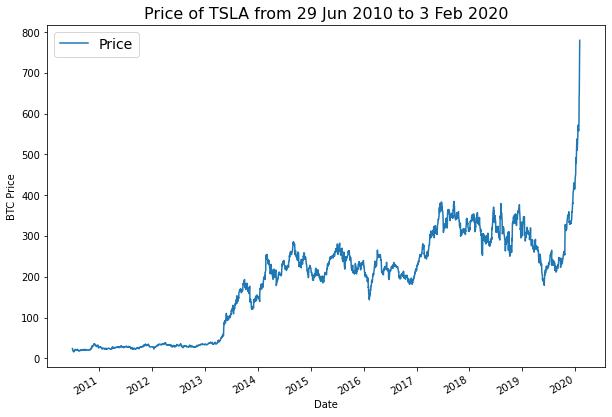

In [4]:
# Plot daily TSLA closing price
tsla_prices.plot(figsize=(10, 7))
plt.ylabel('BTC Price')
plt.title('Price of TSLA from 29 Jun 2010 to 3 Feb 2020', fontsize=16)
plt.legend(fontsize=14);

## Process Data

In [5]:
# Get TSLA date array
timesteps = tsla_prices.index.to_numpy()
prices = tsla_prices['Price'].to_numpy()

In [6]:
# Create train and test splits for time series data
TRAIN_SIZE = 0.8  # 80% train, 20% test - you can change these values as needed
split_size = int(TRAIN_SIZE * len(prices))

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

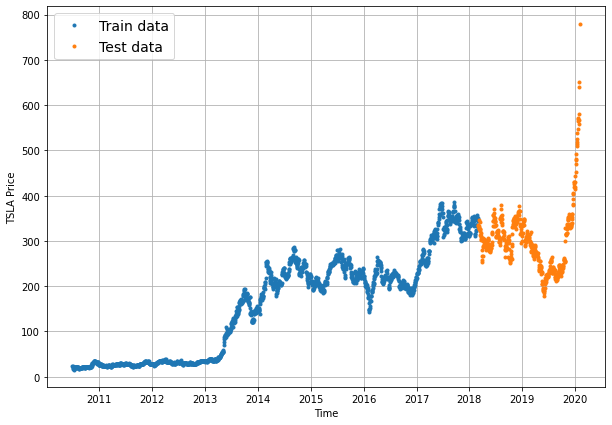

In [7]:
# Plot train / test split
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')

## Prepare Data for Modelling

In [8]:
# Let's setup global variables for window and horizon size
HORIZON = 1  # predict next 1 day
WINDOW_SIZE = 7  # use the past week of TSLA data to make the prediction

In [9]:
# Create train and test windows
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=(1-TRAIN_SIZE))

# Print the train and test window sample sizes
print('Number of Training samples:', len(train_windows))
print('Number of Test samples:', len(test_windows))

Number of Training samples: 1927
Number of Test samples: 482


In [10]:
# Time to make our dataset performant using the tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(train_windows)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels)

test_features_dataset = tf.data.Dataset.from_tensor_slices(test_windows)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(test_labels)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2022-05-01 20:26:21.829220: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train N-BEATS Model

In [11]:
# Set hyperparameters
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

hparams = {
    'input_size': INPUT_SIZE,
    'theta_size': THETA_SIZE,
    'horizon': HORIZON,
    'n_neurons': N_NEURONS,
    'n_layers': N_LAYERS,
    'n_stacks': N_STACKS,
    'n_epochs': N_EPOCHS,
    'model-dir': 'output/nbeats_model'
}

In [12]:
# Train N-BEATS model
model.train_evaluate(hparams=hparams, train_dataset=train_dataset, test_dataset=test_dataset);

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [ ]:
# Load model and make predictions
nbeats_model = tf.keras.models.load_model('output/nbeats_model/')
nbeats_model_preds = make_preds(nbeats_model, test_dataset)

## Evaluate N-BEATS Model

In [ ]:
# Evaluate model performance with metric MAE
print('Test MAE:', nbeats_model.evaluate(test_dataset))

In [ ]:
# Plot model predictions versus actual on test data
plt.figure(figsize=(10, 7))

# Account for test_window offset when plotting
OFFSET = 300
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=OFFSET, label='Test data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=nbeats_model_preds, start=OFFSET, format='-', label='nbeats_model_preds')